In [ ]:
#Max addition: I increased regularization on the dense layers by *= 10 ; If this leads to overfitting, we can try to increase

In [ ]:
'''
function ClickConnect(){
  console.log("Connnect Clicked - Start"); 
  document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
  console.log("Connnect Clicked - End"); 
};
setInterval(ClickConnect, 60000)
'''

'\nfunction ClickConnect(){\n  console.log("Connnect Clicked - Start"); \n  document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();\n  console.log("Connnect Clicked - End"); \n};\nsetInterval(ClickConnect, 60000)\n'

In [1]:
import numpy as np
import pandas as pd
import keras
from keras import backend as K
from keras.callbacks import History
import pickle
from keras import initializers
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Activation
from keras.layers.convolutional import Conv1D, MaxPooling1D, ZeroPadding1D
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import glob
import os
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
from sklearn import preprocessing
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier

from sklearn.metrics import roc_curve,roc_auc_score

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
folder_root = '/content/drive/My Drive/BrainStateClassification/code/'#Update to your main folder, this folder must contain a data and a result subfolder
folder_data = folder_root + 'data/' #folder containing all the .mat files
folder_result = folder_root + 'data/plateau' #folder where your models and logs will be stored


In [4]:
os.chdir(folder_data)

In [5]:
Y = np.loadtxt('Y_hyp_v2.csv',delimiter=",")
X = np.loadtxt('X_hyp_v2.csv',delimiter=",")

In [6]:
from collections import Counter
Counter(Y)

Counter({0.0: 2200, 1.0: 1100, 2.0: 1100})

In [ ]:
np.shape(X)

(4400, 300)

In [ ]:
#bias_regularization = 0.01
#kernel_regularization = 0.01
bias_regularization = 0.005
kernel_regularization = 0.005
#bias_regularization = 0.05
#kernel_regularization = 0.05

def create_model():
    model = Sequential()
    model.add(Conv1D(128, (10), input_shape=(300,1)))
    model.add(Conv1D(128, (10)))
    model.add(Conv1D(128, (10)))
    model.add(Conv1D(64, (10)))
    model.add(Conv1D(64, (10)))
    model.add(Conv1D(64, (10)))
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(1024, activation='relu',kernel_regularizer=keras.regularizers.l1(kernel_regularization),
                           bias_regularizer=keras.regularizers.l1(bias_regularization)))
                    #,activity_regularizer=keras.regularizers.l1(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu',kernel_regularizer=keras.regularizers.l1(kernel_regularization),
                       bias_regularizer=keras.regularizers.l1(bias_regularization)))
    # Try eliminate just one dense layer below
    model.add(Dense(256, activation='relu',kernel_regularizer=keras.regularizers.l1(kernel_regularization),
                    bias_regularizer=keras.regularizers.l1(bias_regularization)))
    model.add(Dense(128, activation='relu',kernel_regularizer=keras.regularizers.l1(kernel_regularization),
                bias_regularizer=keras.regularizers.l1(bias_regularization)))
    model.add(Dense(64, activation='relu',kernel_regularizer=keras.regularizers.l1(kernel_regularization),
              bias_regularizer=keras.regularizers.l1(bias_regularization)))
    model.add(Dense(32, activation='relu',kernel_regularizer=keras.regularizers.l1(kernel_regularization),
          bias_regularizer=keras.regularizers.l1(bias_regularization)))
    model.add(Dense(16, activation='relu',kernel_regularizer=keras.regularizers.l1(kernel_regularization),
      bias_regularizer=keras.regularizers.l1(bias_regularization)))
    model.add(Dense(3, activation='softmax')) 
    #print(model.summary())
    return model


In [ ]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 291, 128)          1408      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 282, 128)          163968    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 273, 128)          163968    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 264, 64)           81984     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 255, 64)           41024     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 246, 64)           41024     
_________________________________________________________________
flatten (Flatten)            (None, 15744)             0

# **Manual Cross-Validation over X,y Dataset**

In [ ]:
#Warning: Running this code again will overwrite previously trained models.

tmp = list(range(0,4800,400))
X_Hold_out = [] #Holdout = testing | Max
X_CV=[]
Y_Hold_out = []
Y_CV=[]
for i in range(len(tmp)-1):
    X_Hold_out+=[X[tmp[i]:tmp[i+1]]]
    Y_Hold_out+=[Y[tmp[i]:tmp[i+1]]]
    X_CV += [np.concatenate((X[0:tmp[i]],X[tmp[i+1]:]))]
    Y_CV += [np.concatenate((Y[0:tmp[i]],Y[tmp[i+1]:]))]
N_Leave_One_Subject = len(tmp)-1


for learn_rate in [0.0045]:
#for learn_rate in [0.00045]:
    for leave_one_idx in [0]:#range(N_Leave_One_Subject): 
        print(leave_one_idx)
        X_train = X_CV[leave_one_idx] # 300 refers to N_features
        Y_train = Y_CV[leave_one_idx].reshape(-1,1)
        X_test = X_Hold_out[leave_one_idx]
        Y_test = Y_Hold_out[leave_one_idx]
        
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train).reshape(-1,300,1)
        X_test = scaler.transform(X_test).reshape(-1,300,1)

#Y_..._onehot contains one hot encoded Y_... i.e, if Y[i] = 0, Y_onehot[i] = [1,0,0] 

        X_train, Y_train = RandomOverSampler(random_state=0).fit_resample(X_train.reshape(-1,300),Y_train.flatten())
#        X_train, Y_train = RandomUnderSampler(random_state=0).fit_resample(X_train.reshape(-1,300),Y_train.flatten())
        X_train = X_train.reshape(-1,300,1)
        X_test, Y_test = RandomOverSampler(random_state=0).fit_resample(X_test.reshape(-1,300),Y_test.flatten())
#        X_test, Y_test = RandomUnderSampler(random_state=0).fit_resample(X_test.reshape(-1,300),Y_test.flatten())
        X_test = X_test.reshape(-1,300,1)

        Y_train_onehot = np.eye(3)[Y_train.astype(int)].reshape(-1,3)
        Y_test_onehot = np.eye(3)[Y_test.astype(int)].reshape(-1,3)


        print("to create")
        model = create_model()

        savedpath = './plateau'
        print("created")
        #If the model weights have not yet been computed (i.e model did not exist), create weights file, otherwise, load the weights. Files are located in the plateau folder
        best_model_path=os.path.join(savedpath,f"weights_holdout_regularized_{leave_one_idx}_{learn_rate}.best.hdf5")
        print(best_model_path)
        if len(glob.glob(os.path.join(savedpath, f"weights_holdout_regularized_{leave_one_idx}_{learn_rate}.best.hdf5")))==0:
            print("created a new model")   
        else:
            print("loaded weights from file")
            model.load_weights(os.path.join(savedpath,f'weights_holdout_regularized_{leave_one_idx}_{learn_rate}.best.hdf5'))
        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adam(lr=learn_rate),
                      metrics=['accuracy'])
        batch_size = 64
        epochs = 5000
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=50, min_lr=0.00001) #Reduce learning rate when a metric has stopped improving.
        checkpoint = ModelCheckpoint(best_model_path, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
        csv_logger = keras.callbacks.CSVLogger(os.path.join(savedpath, f'training_holdout_regularized_{leave_one_idx}_{learn_rate}.log'))
        print("Before Fit")
        model.fit(X_train, Y_train_onehot,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(X_test, Y_test_onehot),
                  callbacks=[csv_logger,checkpoint,reduce_lr])#[csv_logger,checkpoint,reduce_lr])
        print(model.summary())
        model.load_weights(os.path.join(savedpath,f'weights_holdout_regularized_{leave_one_idx}_{learn_rate}.best.hdf5'))
        score, acc = model.evaluate(X_test, Y_test_onehot, batch_size=batch_size,verbose=0)
        with open(os.path.join(savedpath,f"test_holdout_regularized_{leave_one_idx}_{learn_rate}.log"), 'a') as f:
            print("...Test size:" + "{:.3f}".format(X_test.shape[0]), file=f)
            print("...Test score:"+"{:.3f}".format(score),file=f)
            print("...Testing accuracy:" + "{:.3f}".format(acc), file=f)
        print(f'Test Accuracy for learning rate {learn_rate} CV index {leave_one_idx} is :', "{:.3f}".format(acc))


0
to create
created
./plateau/weights_holdout_regularized_0_0.0045.best.hdf5
created a new model
Before Fit


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
94/94 [==============================] - 1s 12ms/step - loss: 0.7867 - accuracy: 0.6488 - val_loss: 0.7311 - val_accuracy: 0.6600
Epoch 2524/5000
94/94 [==============================] - 1s 13ms/step - loss: 0.7849 - accuracy: 0.6405 - val_loss: 0.7359 - val_accuracy: 0.6417
Epoch 2525/5000
94/94 [==============================] - 1s 13ms/step - loss: 0.7985 - accuracy: 0.6432 - val_loss: 0.7468 - val_accuracy: 0.6433
Epoch 2526/5000
94/94 [==============================] - 1s 13ms/step - loss: 0.8027 - accuracy: 0.6453 - val_loss: 0.7504 - val_accuracy: 0.6517
Epoch 2527/5000
94/94 [==============================] - 1s 13ms/step - loss: 0.8048 - accuracy: 0.6365 - val_loss: 0.7380 - val_accuracy: 0.6567
Epoch 2528/5000
94/94 [==============================] - 1s 14ms/step - loss: 0.7918 - accuracy: 0.6425 - val_loss: 0.7460 - val_accuracy: 0.6500
Epoch 2529/5000
94/94 [==============================] - 1s 14ms/step - loss: 0.7928 - accuracy: 0.6435 

In [ ]:
 ls

acc_cv0_lr_0.0045.png   acc_cv8_lr_0.0045.png    loss_cv6_lr_0.0045.png
acc_cv10_lr_0.0045.png  acc_cv9_lr_0.0045.png    loss_cv7_lr_0.0045.png
acc_cv1_lr_0.0045.png   loss_cv0_lr_0.0045.png   loss_cv8_lr_0.0045.png
acc_cv2_lr_0.0045.png   loss_cv10_lr_0.0045.png  loss_cv9_lr_0.0045.png
acc_cv3_lr_0.0045.png   loss_cv1_lr_0.0045.png   old_plots/
acc_cv4_lr_0.0045.png   loss_cv2_lr_0.0045.png   plateau/
acc_cv5_lr_0.0045.png   loss_cv3_lr_0.0045.png   X_hyp_v2.csv
acc_cv6_lr_0.0045.png   loss_cv4_lr_0.0045.png   Y_hyp_v2.csv
acc_cv7_lr_0.0045.png   loss_cv5_lr_0.0045.png


In [ ]:
  cd ./

/content


## Draw plots for each model

Cross-Validation Number  0 :


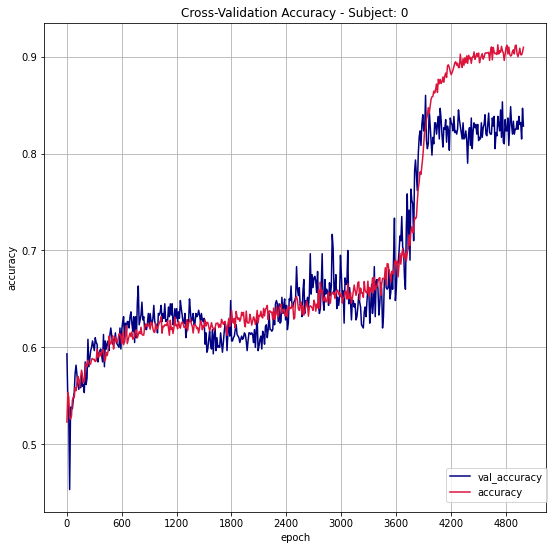

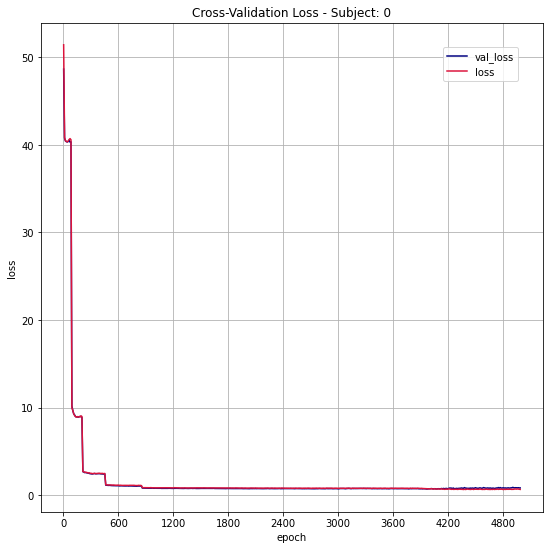

Cross-Validation Number  1 :


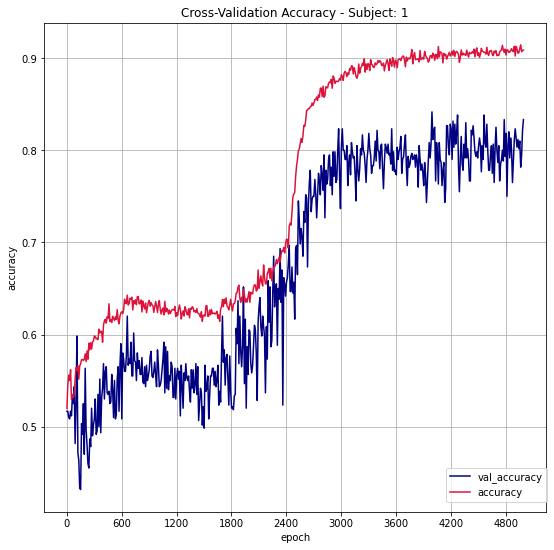

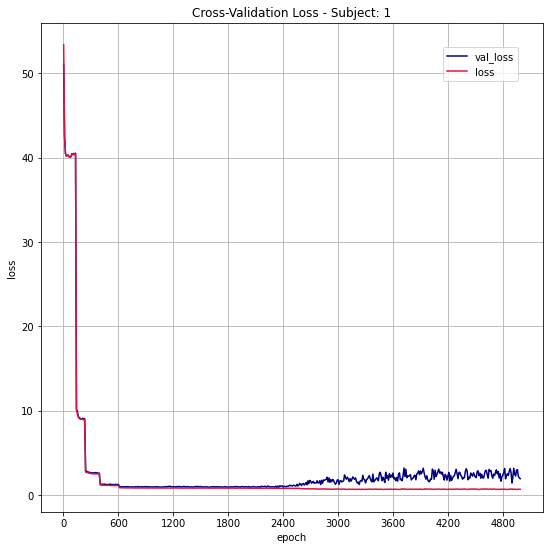

Cross-Validation Number  2 :


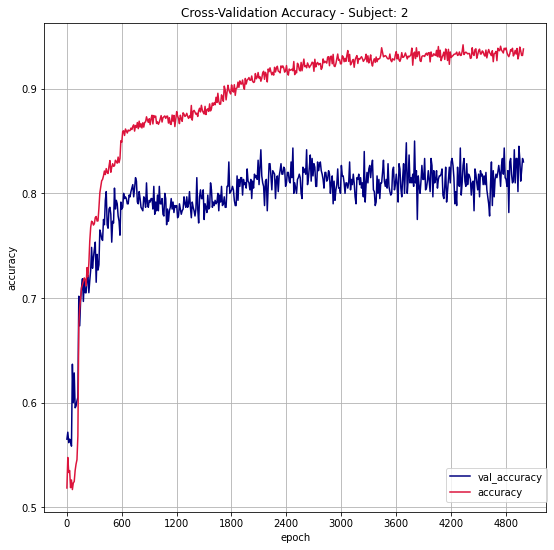

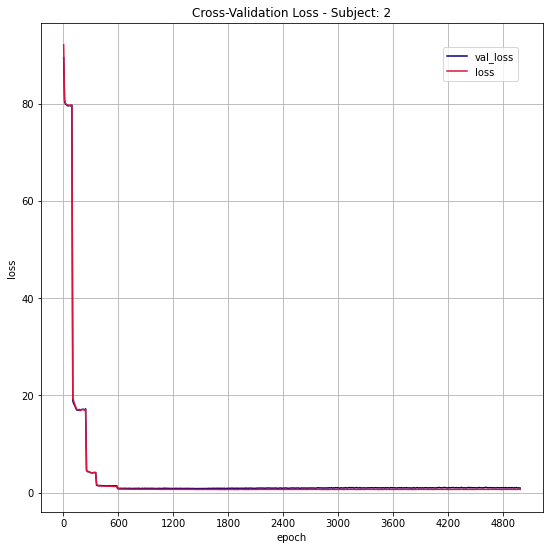

Cross-Validation Number  3 :


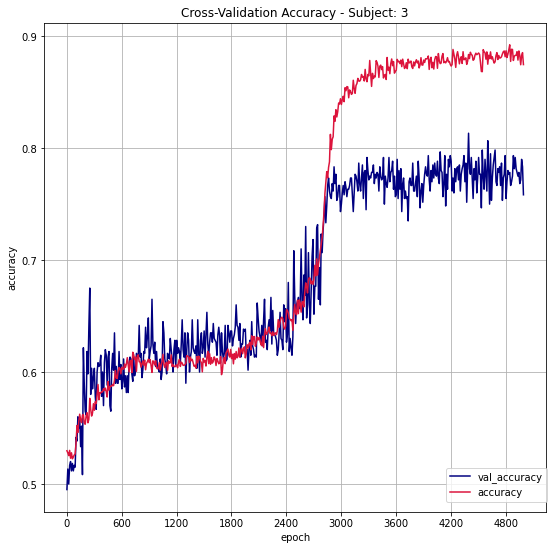

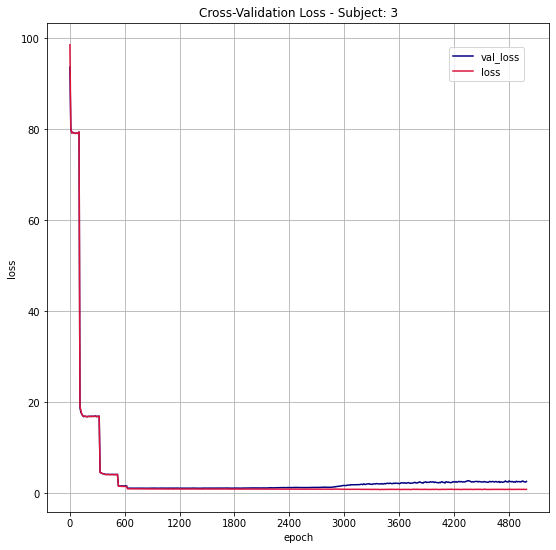

Cross-Validation Number  4 :


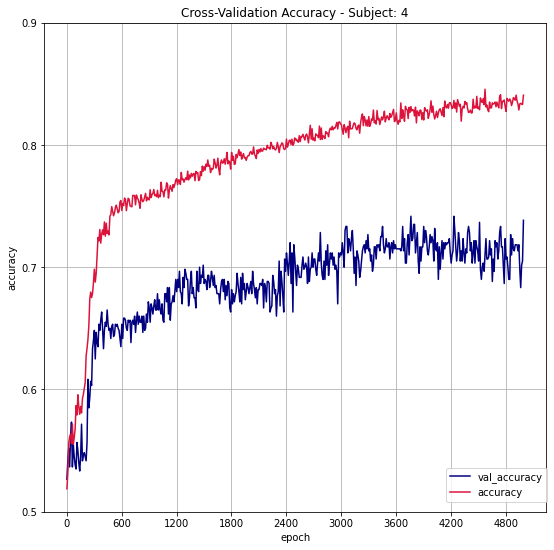

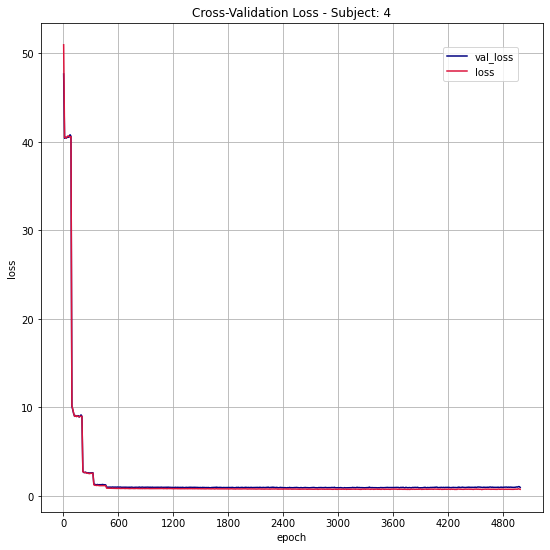

Cross-Validation Number  5 :


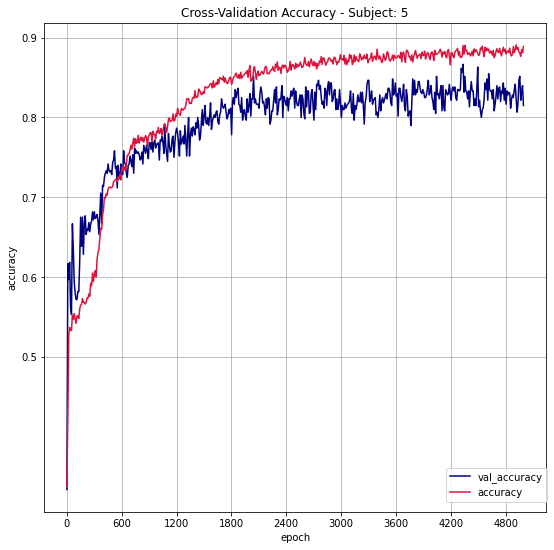

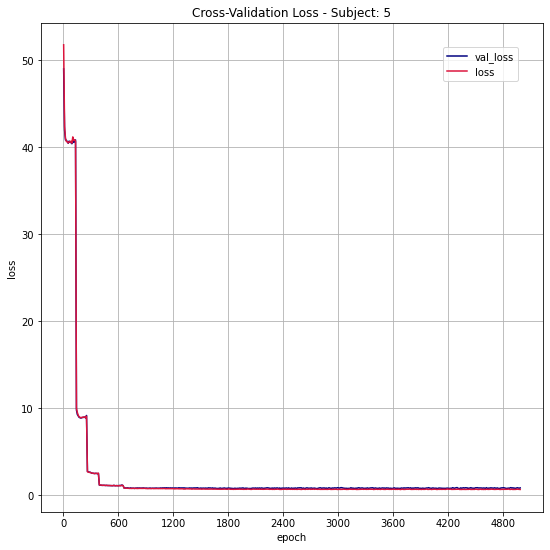

Cross-Validation Number  6 :


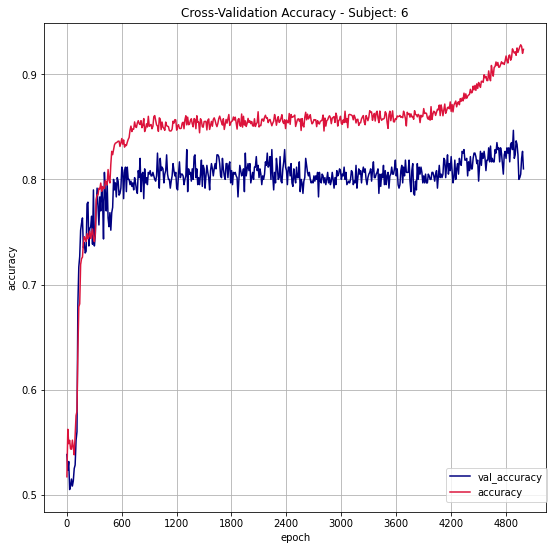

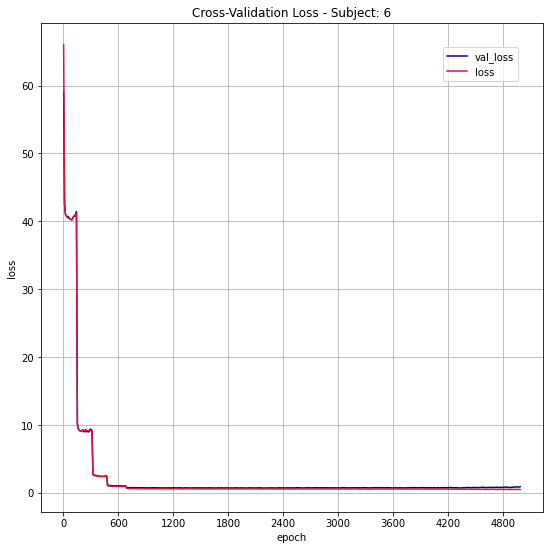

Cross-Validation Number  7 :


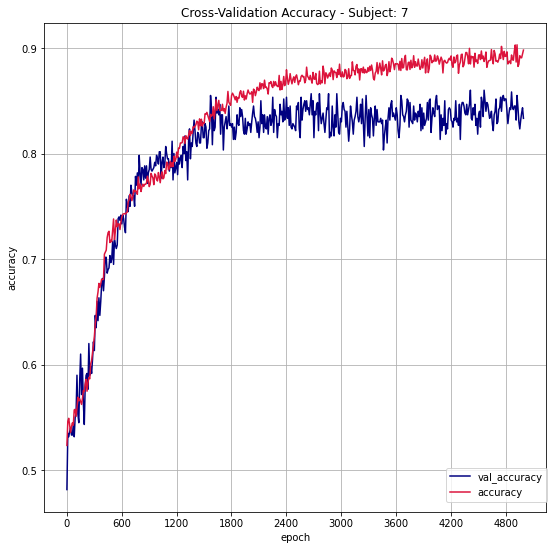

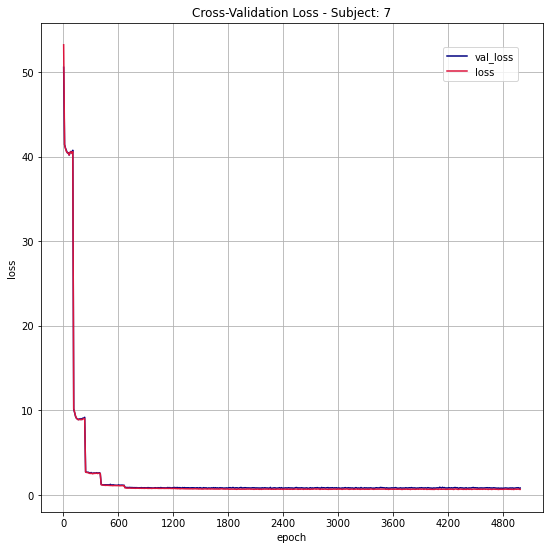

Cross-Validation Number  8 :


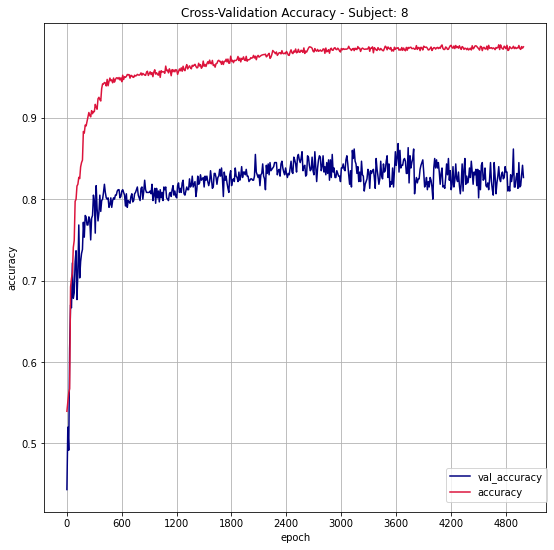

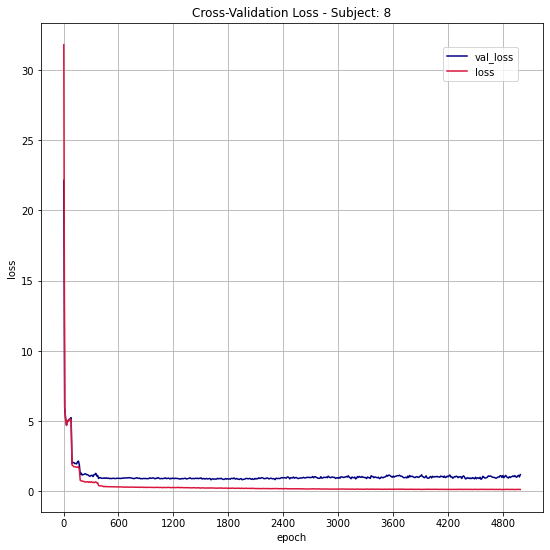

Cross-Validation Number  9 :


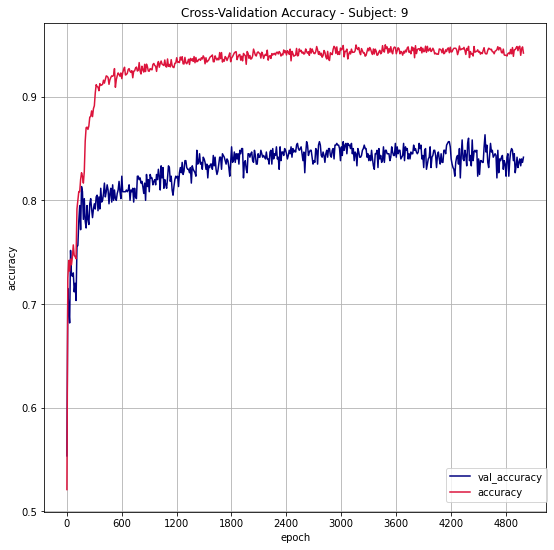

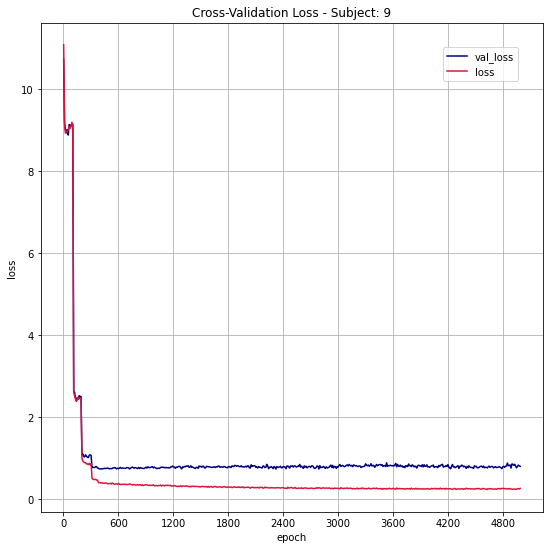

Cross-Validation Number  10 :


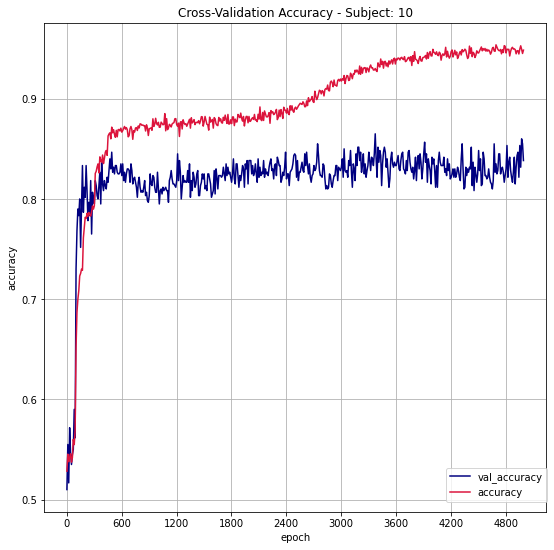

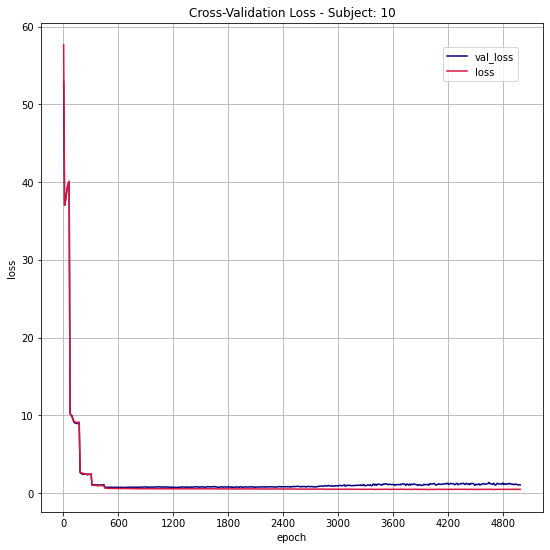

In [ ]:
import pandas as pd
tmp = list(range(0,4800,400))
N_Leave_One_Subject = len(tmp)-1
#changed vdcnn_test to plateau
for learn_rate in [0.0045]:
  for leave_one_idx in range(N_Leave_One_Subject):
      model_num = leave_one_idx
      print('Cross-Validation Number ',leave_one_idx,':')
      train_result = pd.read_csv(os.path.join('./plateau',f'training_holdout_regularized_{model_num}_{learn_rate}.log'))
      train_result = train_result[train_result.epoch < 5001][train_result.epoch > 1].iloc[::10]
      
      ax = figure(0).gca()
      ax.plot('epoch','val_accuracy',data=train_result,color='navy')
      ax.plot('epoch','accuracy',data=train_result,color='crimson')
      ax.xaxis.set_major_locator(MaxNLocator(integer=True))
      ax.legend(bbox_to_anchor=(0.8, 0.09), loc='upper left', borderaxespad=0.)
      plt.title('Cross-Validation Accuracy - Subject: '+str(leave_one_idx))
      ax.set_xlabel('epoch')
      ax.set_ylabel('accuracy')
      ax.set_yticks(np.arange(0.5,1,0.1))
      fig = ax.get_figure()
      fig.set_figheight(9)
      fig.set_figwidth(9) 
      plt.grid()
      fig.savefig("acc_cv"+str(leave_one_idx)+"_lr_"+str(learn_rate)+".png")

      ax2 = figure(1).gca()
      ax2.plot('epoch','val_loss',data=train_result,color='navy')
      ax2.plot('epoch','loss',data=train_result,color='crimson')
      ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
      ax2.legend(bbox_to_anchor=(0.8, 0.95), loc='upper left', borderaxespad=0.)
      ax2.set_xlabel('epoch')
      ax2.set_ylabel('loss')
      plt.title('Cross-Validation Loss - Subject: '+str(leave_one_idx))

      fig2 = ax2.get_figure()
      fig2.set_figheight(9)
      fig2.set_figwidth(9)  
      plt.grid()    
      fig2.savefig("loss_cv"+str(leave_one_idx)+"_lr_"+str(learn_rate)+".png")
      
      show()

## Error for each fold

In [ ]:
train_result

,epoch,accuracy,loss,val_accuracy,val_loss
2,2,0.523000,51.437332,0.593333,48.664043
12,12,0.553333,40.868073,0.546667,40.757729
22,22,0.548500,40.454777,0.531667,40.454899
32,32,0.528000,40.421520,0.453333,40.369999
42,42,0.526000,40.344913,0.538333,40.334499
...,...,...,...,...,...
2952,2952,0.658667,0.777137,0.640000,0.736028
2962,2962,0.659167,0.787479,0.651667,0.749778
2972,2972,0.654500,0.784784,0.643333,0.739246
2982,2982,0.656500,0.784011,0.651667,0.744175


## Ignore this part for now

In [ ]:
=#Might have to change learning_rates to single learning rate
##This one only loads the weights
def create_model():
    model = Sequential()
    model.add(Conv1D(128, (10), input_shape=(300,1)))
    model.add(Conv1D(128, (10)))
    model.add(Conv1D(128, (10)))
    model.add(Conv1D(64, (10)))
    model.add(Conv1D(64, (10)))
    model.add(Conv1D(64, (10)))
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(1024, activation='relu',kernel_regularizer=keras.regularizers.l1(0.001),
                           bias_regularizer=keras.regularizers.l1(0.01)))
                    #,activity_regularizer=keras.regularizers.l1(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu',kernel_regularizer=keras.regularizers.l1(0.001),
                       bias_regularizer=keras.regularizers.l1(0.001)))
    # Try eliminate just one dense layer below
    model.add(Dense(256, activation='relu',kernel_regularizer=keras.regularizers.l1(0.001),
                    bias_regularizer=keras.regularizers.l1(0.001)))
    model.add(Dense(128, activation='relu',kernel_regularizer=keras.regularizers.l1(0.001),
                bias_regularizer=keras.regularizers.l1(0.001)))
    model.add(Dense(64, activation='relu',kernel_regularizer=keras.regularizers.l1(0.001),
              bias_regularizer=keras.regularizers.l1(0.001)))
    model.add(Dense(32, activation='relu',kernel_regularizer=keras.regularizers.l1(0.001),
          bias_regularizer=keras.regularizers.l1(0.001)))
    model.add(Dense(16, activation='relu',kernel_regularizer=keras.regularizers.l1(0.001),
      bias_regularizer=keras.regularizers.l1(0.001)))
    model.add(Dense(3, activation='softmax')) 
    print(model.summary())
    return model


learning_rates = [0.00031622776601683794,0.00045]

acc_hold_out = np.zeros((N_Leave_One_Subject, len(learning_rates)))
loss_hold_out = np.zeros((N_Leave_One_Subject, len(learning_rates)))
tmp = list(range(0,4800,400))
X_Hold_out = []
X_CV=[]
Y_Hold_out = []
Y_CV=[]
for i in range(len(tmp)-1):
    X_Hold_out+=[X[tmp[i]:tmp[i+1]]]
    Y_Hold_out+=[Y[tmp[i]:tmp[i+1]]]
    X_CV += [np.concatenate((X[0:tmp[i]],X[tmp[i+1]:]))]
    Y_CV += [np.concatenate((Y[0:tmp[i]],Y[tmp[i+1]:]))]
N_Leave_One_Subject = len(tmp)-1

print('Test results for hold-out set \n')
for leave_one_idx in range(N_Leave_One_Subject):
    X_train = X_CV[leave_one_idx] # 300 refers to N_features
    Y_train = Y_CV[leave_one_idx].reshape(-1,1)
    X_test = X_Hold_out[leave_one_idx]
    Y_test = Y_Hold_out[leave_one_idx]
    
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train).reshape(-1,300,1)
    X_test = scaler.transform(X_test).reshape(-1,300,1)


    Y_train_onehot = np.eye(3)[Y_train.astype(int)].reshape(-1,3)
    Y_test_onehot = np.eye(3)[Y_test.astype(int)].reshape(-1,3)
    for learn_rate in [0.00045]:
        model=create_model()
        model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=learn_rate),
              metrics=['accuracy'])
        model.load_weights(os.path.join('./plateau',f'weights_holdout_{leave_one_idx}_{learn_rate}.best.hdf5'))
        score, acc = model.evaluate(X_test, Y_test_onehot, batch_size=200,verbose=2)
        acc_hold_out[leave_one_idx] = acc
        loss_hold_out[leave_one_idx] = score
        print('For Holdout subject :', leave_one_idx ,'For learning rate : ', learn_rate)
        print('test_loss :',score, '| test_acc: ',acc,'\n')
print(np.mean(acc_hold_out,axis=0))

**With learning_rate : 0.00045 acc_hold_out.mean()=0.8977272808551788**

Still need to evaluate with learning_rate = 00031622776601683794

In [ ]:

#Define Learning rate & Data
## This is for learning rate parameter tuning
tmp = list(range(0,4800,400))
N_Leave_One_Subject = len(tmp)-1
#learning_rates = np.logspace(-4.5,-3.5,num=10)
learning_rates = [0.00045]
acc_hold_out = np.zeros((N_Leave_One_Subject, len(learning_rates)))
loss_hold_out = np.zeros((N_Leave_One_Subject, len(learning_rates)))

X_Hold_out = [] #Holdout = testing | Max
X_CV=[]
Y_Hold_out = []
Y_CV=[]
for i in range(len(tmp)-1):
    X_Hold_out+=[X[tmp[i]:tmp[i+1]]]
    Y_Hold_out+=[Y[tmp[i]:tmp[i+1]]]
    X_CV += [np.concatenate((X[0:tmp[i]],X[tmp[i+1]:]))]
    Y_CV += [np.concatenate((Y[0:tmp[i]],Y[tmp[i+1]:]))]
N_Leave_One_Subject = len(tmp)-1


#Training
for learn_rate_idx in range(len(learning_rates)):
      for leave_one_idx in range(1,N_Leave_One_Subject): 
        learn_rate = learning_rates[learn_rate_idx]
        print(leave_one_idx)

        X_train = X_CV[leave_one_idx] # 300 refers to N_features
        Y_train = Y_CV[leave_one_idx].reshape(-1,1)
        X_test = X_Hold_out[leave_one_idx]
        Y_test = Y_Hold_out[leave_one_idx]
        
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train).reshape(-1,300,1)
        X_test = scaler.transform(X_test).reshape(-1,300,1)

#Y_..._onehot contains one hot encoded Y_... i.e, if Y[i] = 0, Y_onehot[i] = [1,0,0] 

        Y_train_onehot = np.eye(3)[Y_train.astype(int)].reshape(-1,3)
        Y_test_onehot = np.eye(3)[Y_test.astype(int)].reshape(-1,3)
        print("to create")
        model = create_model()
        idx = 0

        savedpath = './plateau/variable_learn_rate'
        print("created")
        #If the model weights have not yet been computed (i.e model did not exist), create weights file, otherwise, load the weights. Files are located in the plateau folder
        best_model_path=os.path.join(savedpath,f"weights_holdout_{leave_one_idx}_{learn_rate}.best.hdf5")
        print(best_model_path)
        if len(glob.glob(os.path.join(savedpath, f"weights_holdout_{leave_one_idx}_{learn_rate}.best.hdf5")))==0:
            print("created a new model")   
        else:
            print("loaded weights from file")
            model.load_weights(os.path.join(savedpath,f'weights_holdout_{leave_one_idx}_{learn_rate}.best.hdf5'))
        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adam(lr=learn_rate),
                      metrics=['accuracy'])
        batch_size = 200
        epochs = 20 #20 epochs now
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=50, min_lr=0.00001) #Reduce learning rate when a metric has stopped improving.
        checkpoint = ModelCheckpoint(best_model_path, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
        csv_logger = keras.callbacks.CSVLogger(os.path.join(savedpath, f'training_holdout_{leave_one_idx}_{learn_rate}_{idx}.log'))

        print("Before Fit")
        model.fit(X_train, Y_train_onehot,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=0,
                  validation_data=(X_test, Y_test_onehot),
                  callbacks=[csv_logger,checkpoint,reduce_lr])#[csv_logger,checkpoint,reduce_lr])
        print(model.summary())
        model.load_weights(os.path.join(savedpath,f'weights_holdout_{leave_one_idx}_{learn_rate}.best.hdf5'))
        score, acc = model.evaluate(X_test, Y_test_onehot, batch_size=batch_size,verbose=0)
        print(acc)
        print(score)
        acc_hold_out[leave_one_idx][learn_rate_idx] = acc
        loss_hold_out[leave_one_idx][learn_rate_idx] = score
        idx += 1
print(np.mean(acc_hold_out,axis=0))

In [ ]:
tmp = list(range(0,4800,400))
N_Leave_One_Subject = len(tmp)-1
learning_rates = np.logspace(-4.5,-3.5,num=10)
learning_rates = [learning_rates[-1],0.00045]
acc_hold_out = np.zeros((N_Leave_One_Subject, len(learning_rates)))
loss_hold_out = np.zeros((N_Leave_One_Subject, len(learning_rates)))

X_Hold_out = [] #Holdout = testing | Max
X_CV=[]
Y_Hold_out = []
Y_CV=[]
for i in range(len(tmp)-1):
    X_Hold_out+=[X[tmp[i]:tmp[i+1]]]
    Y_Hold_out+=[Y[tmp[i]:tmp[i+1]]]
    X_CV += [np.concatenate((X[0:tmp[i]],X[tmp[i+1]:]))]
    Y_CV += [np.concatenate((Y[0:tmp[i]],Y[tmp[i+1]:]))]

batch_size = 200

for learn_rate_idx in range(len(learning_rates)):
      for leave_one_idx in range(N_Leave_One_Subject): 
        learn_rate = learning_rates[learn_rate_idx]

        X_train = X_CV[leave_one_idx] # 300 refers to N_features
        Y_train = Y_CV[leave_one_idx].reshape(-1,1)
        X_test = X_Hold_out[leave_one_idx]
        Y_test = Y_Hold_out[leave_one_idx]
        
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train).reshape(-1,300,1)
        X_test = scaler.transform(X_test).reshape(-1,300,1)

#Y_..._onehot contains one hot encoded Y_... i.e, if Y[i] = 0, Y_onehot[i] = [1,0,0] 

        Y_train_onehot = np.eye(3)[Y_train.astype(int)].reshape(-1,3)
        Y_test_onehot = np.eye(3)[Y_test.astype(int)].reshape(-1,3)
        model = create_model()
        idx = 0

        savedpath = './plateau/variable_learn_rate'

        #If the model weights have not yet been computed (i.e model did not exist), create weights file, otherwise, load the weights. Files are located in the plateau folder
        best_model_path=os.path.join(savedpath,f"weights_holdout_{leave_one_idx}_{learn_rate}.best.hdf5")
        #print(best_model_path)
        if len(glob.glob(os.path.join(savedpath, f"weights_holdout_{leave_one_idx}_{learn_rate}.best.hdf5")))==0:
            #print("created a new model")   
            pass
        else:
            #print("loaded weights from file")
            model.load_weights(os.path.join(savedpath,f'weights_holdout_{leave_one_idx}_{learn_rate}.best.hdf5'))
        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adam(lr=learn_rate),
                      metrics=['accuracy'])
        model.load_weights(os.path.join(savedpath,f'weights_holdout_{leave_one_idx}_{learn_rate}.best.hdf5'))
        score, acc = model.evaluate(X_test, Y_test_onehot, batch_size=batch_size,verbose=0)
        #print(acc)
        #print(score)
        acc_hold_out[leave_one_idx][learn_rate_idx] = acc
        loss_hold_out[leave_one_idx][learn_rate_idx] = score
        idx += 1
print(np.mean(acc_hold_out,axis=0))

In [ ]:
print(acc_hold_out.mean(axis=0))
print(learning_rates[0])

## Comparison with other models

Here we compare the 1DCNN performance with SVM, XGBoost

In [ ]:
rbf_svm_scores = []

tmp = list(range(0,4800,400))
X_Hold_out = [] #Holdout = testing | Max
X_CV=[]
Y_Hold_out = []
Y_CV=[]
for i in range(len(tmp)-1):
    X_Hold_out+=[X[tmp[i]:tmp[i+1]]]
    Y_Hold_out+=[Y[tmp[i]:tmp[i+1]]]
    X_CV += [np.concatenate((X[0:tmp[i]],X[tmp[i+1]:]))]
    Y_CV += [np.concatenate((Y[0:tmp[i]],Y[tmp[i+1]:]))]
N_Leave_One_Subject = len(tmp)-1


for leave_one_idx in range(N_Leave_One_Subject): 
    print(leave_one_idx)
    X_train = X_CV[leave_one_idx] # 300 refers to N_features
    Y_train = Y_CV[leave_one_idx].reshape(-1,1)
    X_test = X_Hold_out[leave_one_idx]
    Y_test = Y_Hold_out[leave_one_idx]

    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train).reshape(-1,300,1)
    X_test = scaler.transform(X_test).reshape(-1,300,1)

    X_train, Y_train = RandomOverSampler(random_state=0).fit_resample(X_train.reshape(-1,300),Y_train.flatten())
    X_test, Y_test = RandomOverSampler(random_state=0).fit_resample(X_test.reshape(-1,300),Y_test.flatten())

    svm_rbf = SVC(kernel='rbf')
    svm_rbf.fit(X_train,Y_train)
    rbf_svm_scores.append(svm_rbf.score(X_test,Y_test))
    print(rbf_svm_scores[-1])




0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7666666666666667
1


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.83
2


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7766666666666666
3


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7666666666666667
4


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7066666666666667
5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.8216666666666667
6


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7966666666666666
7


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.8316666666666667
8


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7516666666666667
9


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7666666666666667
10


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.8383333333333334


In [ ]:
linear_svm_scores = []


for leave_one_idx in range(N_Leave_One_Subject): 
    print(leave_one_idx)
    X_train = X_CV[leave_one_idx] # 300 refers to N_features
    Y_train = Y_CV[leave_one_idx].reshape(-1,1)
    X_test = X_Hold_out[leave_one_idx]
    Y_test = Y_Hold_out[leave_one_idx]

    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train).reshape(-1,300,1)
    X_test = scaler.transform(X_test).reshape(-1,300,1)

    X_train, Y_train = RandomOverSampler(random_state=0).fit_resample(X_train.reshape(-1,300),Y_train.flatten())
    X_test, Y_test = RandomOverSampler(random_state=0).fit_resample(X_test.reshape(-1,300),Y_test.flatten())

    svm_linear = LinearSVC()
    svm_linear.fit(X_train,Y_train)
    linear_svm_scores.append(svm_linear.score(X_test,Y_test))
    print(linear_svm_scores[-1])

0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn

0.7633333333333333
1


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7633333333333333
2


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7533333333333333
3


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7666666666666667
4


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.715
5


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7583333333333333
6


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.715
7


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7733333333333333
8


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7466666666666667
9


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.75
10
0.715


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
random_forest_scores = []


for leave_one_idx in range(N_Leave_One_Subject): 
    print(leave_one_idx)
    X_train = X_CV[leave_one_idx] # 300 refers to N_features
    Y_train = Y_CV[leave_one_idx].reshape(-1,1)
    X_test = X_Hold_out[leave_one_idx]
    Y_test = Y_Hold_out[leave_one_idx]

    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train).reshape(-1,300,1)
    X_test = scaler.transform(X_test).reshape(-1,300,1)

    X_train, Y_train = RandomOverSampler(random_state=0).fit_resample(X_train.reshape(-1,300),Y_train.flatten())
    X_test, Y_test = RandomOverSampler(random_state=0).fit_resample(X_test.reshape(-1,300),Y_test.flatten())

    random_forest = RandomForestClassifier()
    random_forest.fit(X_train,Y_train)
    random_forest_scores.append(random_forest.score(X_test,Y_test))
    print(random_forest_scores[-1])

0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7233333333333334
1


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.765
2


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.75
3


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.6966666666666667
4


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.6866666666666666
5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7533333333333333
6


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7566666666666667
7


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7433333333333333
8


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7116666666666667
9


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7283333333333334
10


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.82


In [ ]:

xgb_scores = []


for leave_one_idx in range(N_Leave_One_Subject): 
    print(leave_one_idx)
    X_train = X_CV[leave_one_idx] # 300 refers to N_features
    Y_train = Y_CV[leave_one_idx].reshape(-1,1)
    X_test = X_Hold_out[leave_one_idx]
    Y_test = Y_Hold_out[leave_one_idx]

    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train).reshape(-1,300,1)
    X_test = scaler.transform(X_test).reshape(-1,300,1)

    X_train, Y_train = RandomOverSampler(random_state=0).fit_resample(X_train.reshape(-1,300),Y_train.flatten())
    X_test, Y_test = RandomOverSampler(random_state=0).fit_resample(X_test.reshape(-1,300),Y_test.flatten())

    xgb_model = XGBClassifier()
    xgb_model.fit(X_train,Y_train)
    xgb_scores.append(xgb_model.score(X_test,Y_test))
    print(xgb_scores[-1])


0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7183333333333334
1


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.76
2


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7366666666666667
3


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7333333333333333
4


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7
5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.765
6


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7533333333333333
7


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7433333333333333
8


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7783333333333333
9


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7216666666666667
10


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.815


In [ ]:

lda_scores = []


for leave_one_idx in range(N_Leave_One_Subject): 
    print(leave_one_idx)
    X_train = X_CV[leave_one_idx] # 300 refers to N_features
    Y_train = Y_CV[leave_one_idx].reshape(-1,1)
    X_test = X_Hold_out[leave_one_idx]
    Y_test = Y_Hold_out[leave_one_idx]

    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train).reshape(-1,300,1)
    X_test = scaler.transform(X_test).reshape(-1,300,1)

    X_train, Y_train = RandomOverSampler(random_state=0).fit_resample(X_train.reshape(-1,300),Y_train.flatten())
    X_test, Y_test = RandomOverSampler(random_state=0).fit_resample(X_test.reshape(-1,300),Y_test.flatten())

    lda_model = LinearDiscriminantAnalysis()
    lda_model.fit(X_train,Y_train)
    lda_scores.append(lda_model.score(X_test,Y_test))
    print(lda_scores[-1])


0


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7516666666666667
1


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.735
2


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.735
3


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7716666666666666
4


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.705
5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7783333333333333
6


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.735
7


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.79
8


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7383333333333333
9


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7516666666666667
10


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.7416666666666667


In [ ]:
cnn_scores = [0.868,0.853,0.857,0.820,0.747,0.873,0.850,0.868,0.870,0.863,0.870]


In [ ]:
pd.DataFrame({'CNN test acc':cnn_scores,'SVM(Linear) test acc':linear_svm_scores,'SVM(rbf) test acc':rbf_svm_scores,'Random Forest test acc':random_forest_scores,'XGBoost test acc':xgb_scores,'LDA test acc':lda_scores})

,CNN test acc,SVM(Linear) test acc,SVM(rbf) test acc,Random Forest test acc,XGBoost test acc,LDA test acc
0,0.868,0.763333,0.766667,0.723333,0.718333,0.751667
1,0.853,0.763333,0.830000,0.765000,0.760000,0.735000
2,0.857,0.753333,0.776667,0.750000,0.736667,0.735000
3,0.820,0.766667,0.766667,0.696667,0.733333,0.771667
4,0.747,0.715000,0.706667,0.686667,0.700000,0.705000
5,0.873,0.758333,0.821667,0.753333,0.765000,0.778333
6,0.850,0.715000,0.796667,0.756667,0.753333,0.735000
7,0.868,0.773333,0.831667,0.743333,0.743333,0.790000
8,0.870,0.746667,0.751667,0.711667,0.778333,0.738333
9,0.863,0.750000,0.766667,0.728333,0.721667,0.751667


In [ ]:
#**Comparison to the Hanson et al (2004) neural net**
#each subject, we created a 10-hidden node, eight-waymulti-class NN classifier. We used the hyperbolic tangent activa-tion transfer function for its hidden nodes, softmax activation

import keras
def create_model_2():
    model = Sequential()
    model.add(Dense(10, activation='tanh', input_shape= (300,1)))
    model.add(Flatten())
    model.add(Dense(3, activation='softmax')) 
    return model
model = create_model_2()
model.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 300, 10)           20        
_________________________________________________________________
flatten_22 (Flatten)         (None, 3000)              0         
_________________________________________________________________
dense_76 (Dense)             (None, 3)                 9003      
Total params: 9,023
Trainable params: 9,023
Non-trainable params: 0
_________________________________________________________________


In [ ]:
NN_2004_acc = []

batch_size = 64

tmp = list(range(0,4800,400))
X_Hold_out = [] #Holdout = testing | Max
X_CV=[]
Y_Hold_out = []
Y_CV=[]
for i in range(len(tmp)-1):
    X_Hold_out+=[X[tmp[i]:tmp[i+1]]]
    Y_Hold_out+=[Y[tmp[i]:tmp[i+1]]]
    X_CV += [np.concatenate((X[0:tmp[i]],X[tmp[i+1]:]))]
    Y_CV += [np.concatenate((Y[0:tmp[i]],Y[tmp[i+1]:]))]
N_Leave_One_Subject = len(tmp)-1


for learn_rate in [0.0045]:
    for leave_one_idx in range(N_Leave_One_Subject): 
        print(leave_one_idx)
        X_train = X_CV[leave_one_idx] # 300 refers to N_features
        Y_train = Y_CV[leave_one_idx].reshape(-1,1)
        X_test = X_Hold_out[leave_one_idx]
        Y_test = Y_Hold_out[leave_one_idx]
        
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train).reshape(-1,300,1)
        X_test = scaler.transform(X_test).reshape(-1,300,1)

#Y_..._onehot contains one hot encoded Y_... i.e, if Y[i] = 0, Y_onehot[i] = [1,0,0] 

        X_train, Y_train = RandomOverSampler(random_state=0).fit_resample(X_train.reshape(-1,300),Y_train.flatten())
        X_train = X_train.reshape(-1,300,1)
        X_test, Y_test = RandomOverSampler(random_state=0).fit_resample(X_test.reshape(-1,300),Y_test.flatten())
        X_test = X_test.reshape(-1,300,1)

        Y_train_onehot = np.eye(3)[Y_train.astype(int)].reshape(-1,3)
        Y_test_onehot = np.eye(3)[Y_test.astype(int)].reshape(-1,3)

        print("to create")
        model = create_model_2()
        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adam(lr=learn_rate),
                      metrics=['accuracy'])

        batch_size = 32
        epochs = 50 #20 epochs now

        print("Before Fit")
        model.fit(X_train, Y_train_onehot,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1,
                  validation_data=(X_test, Y_test_onehot))
        score, acc = model.evaluate(X_test, Y_test_onehot, batch_size=batch_size,verbose=0)
        print(f'Test Accuracy for learning rate {learn_rate} CV index {leave_one_idx} is :', "{:.3f}".format(acc))
        NN_2004_acc.append(acc)


0
to create
Before Fit
Epoch 1/50


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


188/188 [==============================] - 1s 3ms/step - loss: 0.6891 - accuracy: 0.7300 - val_loss: 0.6072 - val_accuracy: 0.7300
Epoch 2/50
188/188 [==============================] - 0s 3ms/step - loss: 0.5448 - accuracy: 0.7800 - val_loss: 0.6512 - val_accuracy: 0.7300
Epoch 3/50
188/188 [==============================] - 0s 3ms/step - loss: 0.5114 - accuracy: 0.7988 - val_loss: 0.5936 - val_accuracy: 0.7367
Epoch 4/50
188/188 [==============================] - 0s 3ms/step - loss: 0.4798 - accuracy: 0.8072 - val_loss: 0.5965 - val_accuracy: 0.7500
Epoch 5/50
188/188 [==============================] - 0s 3ms/step - loss: 0.4839 - accuracy: 0.8078 - val_loss: 0.5656 - val_accuracy: 0.7500
Epoch 6/50
188/188 [==============================] - 0s 2ms/step - loss: 0.4833 - accuracy: 0.8053 - val_loss: 0.5867 - val_accuracy: 0.7483
Epoch 7/50
188/188 [==============================] - 0s 3ms/step - loss: 0.4596 - accuracy: 0.8127 - val_loss: 0.5981 - val_accuracy: 0.7517
Epoch 8/50
188/18

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


188/188 [==============================] - 1s 4ms/step - loss: 0.7501 - accuracy: 0.7262 - val_loss: 0.5995 - val_accuracy: 0.7417
Epoch 2/50
188/188 [==============================] - 1s 3ms/step - loss: 0.5304 - accuracy: 0.7845 - val_loss: 0.7134 - val_accuracy: 0.7333
Epoch 3/50
188/188 [==============================] - 1s 3ms/step - loss: 0.5239 - accuracy: 0.7950 - val_loss: 0.5246 - val_accuracy: 0.7667
Epoch 4/50
188/188 [==============================] - 1s 3ms/step - loss: 0.4962 - accuracy: 0.8032 - val_loss: 0.6787 - val_accuracy: 0.7250
Epoch 5/50
188/188 [==============================] - 1s 3ms/step - loss: 0.4794 - accuracy: 0.8075 - val_loss: 0.6232 - val_accuracy: 0.7233
Epoch 6/50
188/188 [==============================] - 1s 3ms/step - loss: 0.4485 - accuracy: 0.8203 - val_loss: 0.5876 - val_accuracy: 0.7500
Epoch 7/50
188/188 [==============================] - 1s 3ms/step - loss: 0.4771 - accuracy: 0.8112 - val_loss: 0.5957 - val_accuracy: 0.7433
Epoch 8/50
188/18

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


188/188 [==============================] - 1s 3ms/step - loss: 0.6733 - accuracy: 0.7347 - val_loss: 0.5952 - val_accuracy: 0.7150
Epoch 2/50
188/188 [==============================] - 0s 3ms/step - loss: 0.5254 - accuracy: 0.7840 - val_loss: 0.6397 - val_accuracy: 0.7183
Epoch 3/50
188/188 [==============================] - 0s 3ms/step - loss: 0.5054 - accuracy: 0.8018 - val_loss: 0.6205 - val_accuracy: 0.7267
Epoch 4/50
188/188 [==============================] - 0s 3ms/step - loss: 0.4801 - accuracy: 0.8038 - val_loss: 0.6373 - val_accuracy: 0.7317
Epoch 5/50
188/188 [==============================] - 0s 3ms/step - loss: 0.4683 - accuracy: 0.8133 - val_loss: 0.6243 - val_accuracy: 0.7483
Epoch 6/50
188/188 [==============================] - 0s 3ms/step - loss: 0.4661 - accuracy: 0.8135 - val_loss: 0.5789 - val_accuracy: 0.7400
Epoch 7/50
188/188 [==============================] - 0s 3ms/step - loss: 0.4619 - accuracy: 0.8152 - val_loss: 0.6779 - val_accuracy: 0.6983
Epoch 8/50
188/18

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


188/188 [==============================] - 1s 3ms/step - loss: 0.6920 - accuracy: 0.7278 - val_loss: 0.7805 - val_accuracy: 0.7117
Epoch 2/50
188/188 [==============================] - 1s 3ms/step - loss: 0.5165 - accuracy: 0.7932 - val_loss: 0.7198 - val_accuracy: 0.7333
Epoch 3/50
188/188 [==============================] - 0s 3ms/step - loss: 0.4984 - accuracy: 0.7993 - val_loss: 0.7238 - val_accuracy: 0.7550
Epoch 4/50
188/188 [==============================] - 0s 2ms/step - loss: 0.4909 - accuracy: 0.8015 - val_loss: 0.7916 - val_accuracy: 0.7067
Epoch 5/50
188/188 [==============================] - 0s 3ms/step - loss: 0.4856 - accuracy: 0.8028 - val_loss: 0.7128 - val_accuracy: 0.7550
Epoch 6/50
188/188 [==============================] - 1s 3ms/step - loss: 0.4684 - accuracy: 0.8130 - val_loss: 0.7926 - val_accuracy: 0.7400
Epoch 7/50
188/188 [==============================] - 0s 2ms/step - loss: 0.4462 - accuracy: 0.8223 - val_loss: 0.7216 - val_accuracy: 0.7583
Epoch 8/50
188/18

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


188/188 [==============================] - 1s 3ms/step - loss: 0.6937 - accuracy: 0.7348 - val_loss: 0.6761 - val_accuracy: 0.7033
Epoch 2/50
188/188 [==============================] - 1s 3ms/step - loss: 0.5249 - accuracy: 0.7897 - val_loss: 0.8554 - val_accuracy: 0.6783
Epoch 3/50
188/188 [==============================] - 0s 3ms/step - loss: 0.5087 - accuracy: 0.7957 - val_loss: 0.6517 - val_accuracy: 0.7217
Epoch 4/50
188/188 [==============================] - 0s 3ms/step - loss: 0.4677 - accuracy: 0.8123 - val_loss: 0.6647 - val_accuracy: 0.7200
Epoch 5/50
188/188 [==============================] - 1s 3ms/step - loss: 0.4699 - accuracy: 0.8147 - val_loss: 0.7067 - val_accuracy: 0.7050
Epoch 6/50
188/188 [==============================] - 1s 3ms/step - loss: 0.4454 - accuracy: 0.8195 - val_loss: 0.6901 - val_accuracy: 0.7083
Epoch 7/50
188/188 [==============================] - 1s 3ms/step - loss: 0.4463 - accuracy: 0.8223 - val_loss: 0.8060 - val_accuracy: 0.6617
Epoch 8/50
188/18

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


188/188 [==============================] - 1s 3ms/step - loss: 0.6580 - accuracy: 0.7387 - val_loss: 0.5521 - val_accuracy: 0.7800
Epoch 2/50
188/188 [==============================] - 0s 3ms/step - loss: 0.5387 - accuracy: 0.7850 - val_loss: 0.5548 - val_accuracy: 0.7800
Epoch 3/50
188/188 [==============================] - 0s 3ms/step - loss: 0.5095 - accuracy: 0.7905 - val_loss: 0.5458 - val_accuracy: 0.7417
Epoch 4/50
188/188 [==============================] - 0s 2ms/step - loss: 0.4928 - accuracy: 0.8037 - val_loss: 0.5751 - val_accuracy: 0.7583
Epoch 5/50
188/188 [==============================] - 0s 3ms/step - loss: 0.4726 - accuracy: 0.8087 - val_loss: 0.5724 - val_accuracy: 0.7167
Epoch 6/50
188/188 [==============================] - 0s 3ms/step - loss: 0.4641 - accuracy: 0.8070 - val_loss: 0.5813 - val_accuracy: 0.7550
Epoch 7/50
188/188 [==============================] - 0s 3ms/step - loss: 0.4649 - accuracy: 0.8098 - val_loss: 0.6166 - val_accuracy: 0.7483
Epoch 8/50
188/18

KeyboardInterrupt: ignored

In [ ]:
np.std([0.735, 0.768, 0.740, 0.747, 0.672, 0.742, 0.743, 0.763, 0.778, 0.745, 0.760])

0.02635015329200945

## 1D CNN Confusion Matrix for each run

In [ ]:
from sklearn.metrics import confusion_matrix
import time

confusion_matrices = []
time_array = []

batch_size = 64

tmp = list(range(0,4800,400))
X_Hold_out = [] #Holdout = testing | Max
X_CV=[]
Y_Hold_out = []
Y_CV=[]
for i in range(len(tmp)-1):
    X_Hold_out+=[X[tmp[i]:tmp[i+1]]]
    Y_Hold_out+=[Y[tmp[i]:tmp[i+1]]]
    X_CV += [np.concatenate((X[0:tmp[i]],X[tmp[i+1]:]))]
    Y_CV += [np.concatenate((Y[0:tmp[i]],Y[tmp[i+1]:]))]
N_Leave_One_Subject = len(tmp)-1


for learn_rate in [0.0045]:
    for leave_one_idx in range(N_Leave_One_Subject): 
        print(leave_one_idx)
        X_train = X_CV[leave_one_idx] # 300 refers to N_features
        Y_train = Y_CV[leave_one_idx].reshape(-1,1)
        X_test = X_Hold_out[leave_one_idx]
        Y_test = Y_Hold_out[leave_one_idx]
        
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train).reshape(-1,300,1)
        X_test = scaler.transform(X_test).reshape(-1,300,1)

#Y_..._onehot contains one hot encoded Y_... i.e, if Y[i] = 0, Y_onehot[i] = [1,0,0] 

        X_train, Y_train = RandomOverSampler(random_state=0).fit_resample(X_train.reshape(-1,300),Y_train.flatten())
#        X_train, Y_train = RandomUnderSampler(random_state=0).fit_resample(X_train.reshape(-1,300),Y_train.flatten())
        X_train = X_train.reshape(-1,300,1)
        X_test, Y_test = RandomOverSampler(random_state=0).fit_resample(X_test.reshape(-1,300),Y_test.flatten())
#        X_test, Y_test = RandomUnderSampler(random_state=0).fit_resample(X_test.reshape(-1,300),Y_test.flatten())
        X_test = X_test.reshape(-1,300,1)

        Y_train_onehot = np.eye(3)[Y_train.astype(int)].reshape(-1,3)
        Y_test_onehot = np.eye(3)[Y_test.astype(int)].reshape(-1,3)


        print("to create")
        model = create_model()
        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adam(lr=learn_rate),
                      metrics=['accuracy'])

        savedpath = './plateau'
 
        model.load_weights(os.path.join(savedpath,f'weights_holdout_regularized_{leave_one_idx}_{learn_rate}.best.hdf5'))
 
        start = time.time()


        score, acc = model.evaluate(X_test, Y_test_onehot, batch_size=batch_size,verbose=0)
        y_pred = np.argmax(model.predict(X_test),axis=1)
        confusion_matrices.append(confusion_matrix(Y_test, y_pred))
        time_diff = time.time() - start
        time_array.append(time_diff)
        print('time',time_diff)
        print(f'Test Accuracy for learning rate {learn_rate} CV index {leave_one_idx} is :', "{:.3f}".format(acc))
print(confusion_matrices)

0
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


time 7.806758880615234
Test Accuracy for learning rate 0.0045 CV index 0 is : 0.862
1
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


time 0.6379475593566895
Test Accuracy for learning rate 0.0045 CV index 1 is : 0.853
2
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


time 0.6727120876312256
Test Accuracy for learning rate 0.0045 CV index 2 is : 0.857
3
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


time 0.839277982711792
Test Accuracy for learning rate 0.0045 CV index 3 is : 0.820
4
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


time 0.643136739730835
Test Accuracy for learning rate 0.0045 CV index 4 is : 0.747
5
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


time 0.6347346305847168
Test Accuracy for learning rate 0.0045 CV index 5 is : 0.873
6
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


time 0.6309309005737305
Test Accuracy for learning rate 0.0045 CV index 6 is : 0.850
7
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


time 0.6261661052703857
Test Accuracy for learning rate 0.0045 CV index 7 is : 0.868
8
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


time 0.635195255279541
Test Accuracy for learning rate 0.0045 CV index 8 is : 0.870
9
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


time 0.8412292003631592
Test Accuracy for learning rate 0.0045 CV index 9 is : 0.863
10
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


time 0.6445763111114502
Test Accuracy for learning rate 0.0045 CV index 10 is : 0.870
[array([[187,  12,   1],
       [  2, 173,  25],
       [  0,  43, 157]]), array([[184,  16,   0],
       [  9, 183,   8],
       [ 22,  33, 145]]), array([[180,  12,   8],
       [  8, 176,  16],
       [  3,  39, 158]]), array([[156,   7,  37],
       [ 10, 169,  21],
       [ 14,  19, 167]]), array([[163,  32,   5],
       [ 19, 162,  19],
       [ 16,  61, 123]]), array([[192,   8,   0],
       [ 13, 165,  22],
       [  4,  29, 167]]), array([[190,   6,   4],
       [ 30, 153,  17],
       [  9,  24, 167]]), array([[181,  13,   6],
       [ 10, 181,   9],
       [ 13,  28, 159]]), array([[183,   9,   8],
       [ 20, 152,  28],
       [  1,  12, 187]]), array([[186,   4,  10],
       [  4, 155,  41],
       [  2,  21, 177]]), array([[197,   0,   3],
       [ 13, 156,  31],
       [ 11,  20, 169]])]


In [ ]:
confusion_matrices

[array([[187,  12,   1],
        [  2, 173,  25],
        [  0,  43, 157]]), array([[184,  16,   0],
        [  9, 183,   8],
        [ 22,  33, 145]]), array([[180,  12,   8],
        [  8, 176,  16],
        [  3,  39, 158]]), array([[156,   7,  37],
        [ 10, 169,  21],
        [ 14,  19, 167]]), array([[163,  32,   5],
        [ 19, 162,  19],
        [ 16,  61, 123]]), array([[192,   8,   0],
        [ 13, 165,  22],
        [  4,  29, 167]]), array([[190,   6,   4],
        [ 30, 153,  17],
        [  9,  24, 167]]), array([[181,  13,   6],
        [ 10, 181,   9],
        [ 13,  28, 159]]), array([[183,   9,   8],
        [ 20, 152,  28],
        [  1,  12, 187]]), array([[186,   4,  10],
        [  4, 155,  41],
        [  2,  21, 177]]), array([[197,   0,   3],
        [ 13, 156,  31],
        [ 11,  20, 169]])]

In [ ]:
np.std(confusion_matrices,axis=0)

array([[11.58440102,  7.95233736,  9.87525499],
       [ 7.58423768, 10.76572461,  9.14890591],
       [ 6.8526402 , 13.0972207 , 16.04178428]])

In [ ]:
print(np.mean(NN_2004_acc))
print(np.std(NN_2004_acc))
print(NN_2004_acc)

NameError: ignored

In [ ]:
NN_2004_acc

## 1D CNN AUC, ROC, Precision, Recall for each run

In [ ]:
NEED TO FIND MULTICLASS EXTENSION OF ROC CURVE


In [ ]:
loss_list = []
auc_scores_list = []
roc_list = []

batch_size = 64

tmp = list(range(0,4800,400))
X_Hold_out = [] #Holdout = testing | Max
X_CV=[]
Y_Hold_out = []
Y_CV=[]
for i in range(len(tmp)-1):
    X_Hold_out+=[X[tmp[i]:tmp[i+1]]]
    Y_Hold_out+=[Y[tmp[i]:tmp[i+1]]]
    X_CV += [np.concatenate((X[0:tmp[i]],X[tmp[i+1]:]))]
    Y_CV += [np.concatenate((Y[0:tmp[i]],Y[tmp[i+1]:]))]
N_Leave_One_Subject = len(tmp)-1


for learn_rate in [0.0045]:
    for leave_one_idx in range(N_Leave_One_Subject): 
        print(leave_one_idx)
        X_train = X_CV[leave_one_idx] # 300 refers to N_features
        Y_train = Y_CV[leave_one_idx].reshape(-1,1)
        X_test = X_Hold_out[leave_one_idx]
        Y_test = Y_Hold_out[leave_one_idx]
        
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train).reshape(-1,300,1)
        X_test = scaler.transform(X_test).reshape(-1,300,1)

#Y_..._onehot contains one hot encoded Y_... i.e, if Y[i] = 0, Y_onehot[i] = [1,0,0] 

        X_train, Y_train = RandomOverSampler(random_state=0).fit_resample(X_train.reshape(-1,300),Y_train.flatten())
        X_train = X_train.reshape(-1,300,1)
        X_test, Y_test = RandomOverSampler(random_state=0).fit_resample(X_test.reshape(-1,300),Y_test.flatten())
        X_test = X_test.reshape(-1,300,1)

        Y_train_onehot = np.eye(3)[Y_train.astype(int)].reshape(-1,3)
        Y_test_onehot = np.eye(3)[Y_test.astype(int)].reshape(-1,3)


        print("to create")
        model = create_model()
        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adam(lr=learn_rate),
                      metrics=['accuracy'])

        savedpath = './plateau'
 
        model.load_weights(os.path.join(savedpath,f'weights_holdout_regularized_{leave_one_idx}_{learn_rate}.best.hdf5'))
 
        score, acc = model.evaluate(X_test, Y_test_onehot, batch_size=batch_size,verbose=0)
        loss_list.append(score)

        y_proba_pred = model.predict_proba(X_test)
        auc_score = roc_auc_score(Y_test_onehot,y_proba_pred)
        auc_scores_list.append(auc_score)
        #fpr , tpr , thresholds = roc_curve ( Y_test , y_proba_pred)
        #roc_list.append((fpr,tpr,thresholds))
        print(auc_score)


0
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Instructions for updating:
Please use `model.predict()` instead.
0.9553166666666666
1
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.94365
2
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.9502541666666667
3
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.9161770833333334
4
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.8565583333333332
5
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.9367854166666666
6
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.9526083333333334
7
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.9324354166666667
8
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.9525375
9
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.9408458333333333
10
to create


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


0.94475


In [ ]:
(np.argsort(-y_proba_pred )==0).astype(int)

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1]])

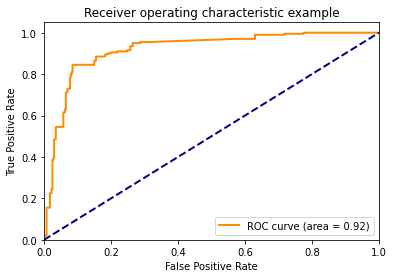

In [ ]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(Y_test_onehot[:, i], y_proba_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_onehot.ravel(),y_proba_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  


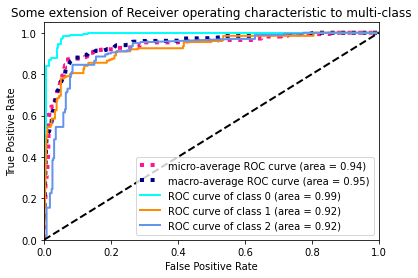

In [ ]:
n_classes=3
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print(np.mean(loss_list))
print(np.std(loss_list))
print(loss_list)

1.1821859370578418
0.48178603969011674
[1.1381261348724365, 1.7412304878234863, 0.6891832947731018, 2.1042087078094482, 0.9315676689147949, 0.8055248260498047, 0.7524473071098328, 0.7757989764213562, 1.9224517345428467, 1.1685853004455566, 0.9749208688735962]


In [ ]:
print(np.mean(auc_scores_list))
print(np.std(auc_scores_list))
print(auc_scores_list)

0.9350206439393939
0.027185664129565013
[0.9586250000000001, 0.94365, 0.9502541666666667, 0.9161770833333334, 0.8565583333333334, 0.9367854166666666, 0.9526083333333334, 0.9324354166666667, 0.9525374999999999, 0.9408458333333334, 0.94475]


## Retrieve Y_pred from the confusion matrix.

### Plot ROC curves: This requires the predict_probas...

In [ ]:
Y_test_onehot.toarray()

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

{0: array([0.    , 0.0375, 1.    ]), 1: array([0.   , 0.065, 1.   ]), 2: array([0.   , 0.095, 1.   ]), 'micro': array([0.        , 0.06583333, 1.        ])} {0: array([0.  , 0.99, 1.  ]), 1: array([0.   , 0.805, 1.   ]), 2: array([0.  , 0.81, 1.  ]), 'micro': array([0.        , 0.86833333, 1.        ])}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


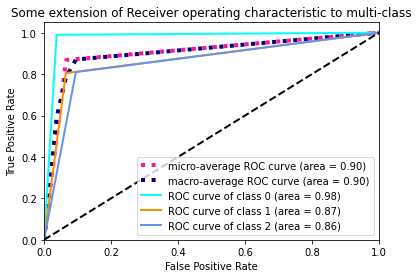

{0: array([0.    , 0.0775, 1.    ]), 1: array([0.    , 0.1225, 1.    ]), 2: array([0.  , 0.02, 1.  ]), 'micro': array([0.        , 0.07333333, 1.        ])} {0: array([0.  , 0.92, 1.  ]), 1: array([0.   , 0.915, 1.   ]), 2: array([0.   , 0.725, 1.   ]), 'micro': array([0.        , 0.85333333, 1.        ])}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


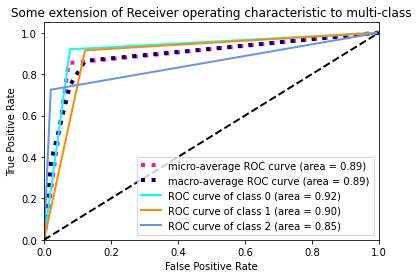

{0: array([0.    , 0.0275, 1.    ]), 1: array([0.    , 0.1275, 1.    ]), 2: array([0.  , 0.06, 1.  ]), 'micro': array([0.        , 0.07166667, 1.        ])} {0: array([0. , 0.9, 1. ]), 1: array([0.  , 0.88, 1.  ]), 2: array([0.  , 0.79, 1.  ]), 'micro': array([0.        , 0.85666667, 1.        ])}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


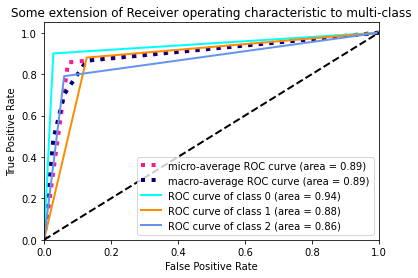

{0: array([0.  , 0.06, 1.  ]), 1: array([0.   , 0.065, 1.   ]), 2: array([0.   , 0.145, 1.   ]), 'micro': array([0.  , 0.09, 1.  ])} {0: array([0.  , 0.78, 1.  ]), 1: array([0.   , 0.845, 1.   ]), 2: array([0.   , 0.835, 1.   ]), 'micro': array([0.  , 0.82, 1.  ])}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


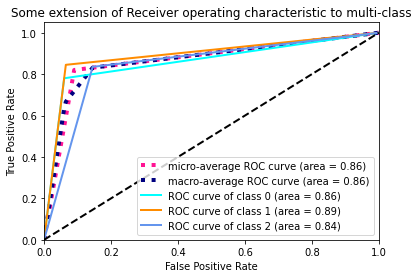

{0: array([0.    , 0.0875, 1.    ]), 1: array([0.    , 0.2325, 1.    ]), 2: array([0.  , 0.06, 1.  ]), 'micro': array([0.        , 0.12666667, 1.        ])} {0: array([0.   , 0.815, 1.   ]), 1: array([0.  , 0.81, 1.  ]), 2: array([0.   , 0.615, 1.   ]), 'micro': array([0.        , 0.74666667, 1.        ])}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


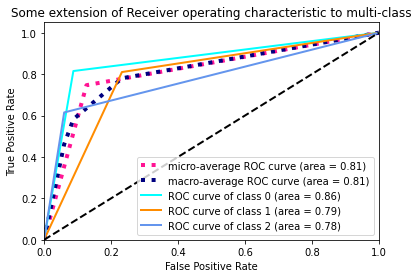

{0: array([0.    , 0.0425, 1.    ]), 1: array([0.    , 0.0925, 1.    ]), 2: array([0.   , 0.055, 1.   ]), 'micro': array([0.        , 0.06333333, 1.        ])} {0: array([0.  , 0.96, 1.  ]), 1: array([0.   , 0.825, 1.   ]), 2: array([0.   , 0.835, 1.   ]), 'micro': array([0.        , 0.87333333, 1.        ])}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


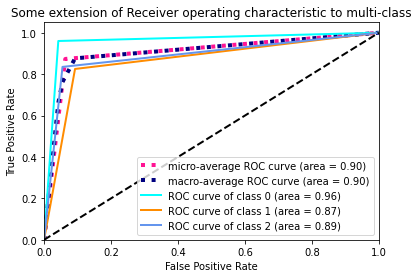

{0: array([0.    , 0.0975, 1.    ]), 1: array([0.   , 0.075, 1.   ]), 2: array([0.    , 0.0525, 1.    ]), 'micro': array([0.   , 0.075, 1.   ])} {0: array([0.  , 0.95, 1.  ]), 1: array([0.   , 0.765, 1.   ]), 2: array([0.   , 0.835, 1.   ]), 'micro': array([0.  , 0.85, 1.  ])}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


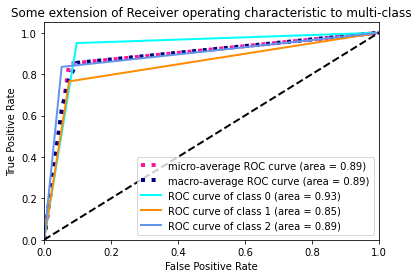

{0: array([0.    , 0.0575, 1.    ]), 1: array([0.    , 0.1025, 1.    ]), 2: array([0.    , 0.0375, 1.    ]), 'micro': array([0.        , 0.06583333, 1.        ])} {0: array([0.   , 0.905, 1.   ]), 1: array([0.   , 0.905, 1.   ]), 2: array([0.   , 0.795, 1.   ]), 'micro': array([0.        , 0.86833333, 1.        ])}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


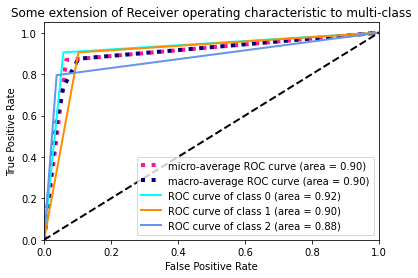

{0: array([0.    , 0.0525, 1.    ]), 1: array([0.    , 0.0525, 1.    ]), 2: array([0.  , 0.09, 1.  ]), 'micro': array([0.   , 0.065, 1.   ])} {0: array([0.   , 0.915, 1.   ]), 1: array([0.  , 0.76, 1.  ]), 2: array([0.   , 0.935, 1.   ]), 'micro': array([0.  , 0.87, 1.  ])}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


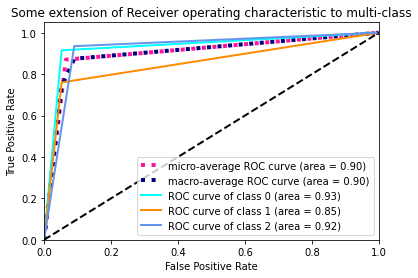

{0: array([0.   , 0.015, 1.   ]), 1: array([0.    , 0.0625, 1.    ]), 2: array([0.    , 0.1275, 1.    ]), 'micro': array([0.        , 0.06833333, 1.        ])} {0: array([0.  , 0.93, 1.  ]), 1: array([0.   , 0.775, 1.   ]), 2: array([0.   , 0.885, 1.   ]), 'micro': array([0.        , 0.86333333, 1.        ])}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


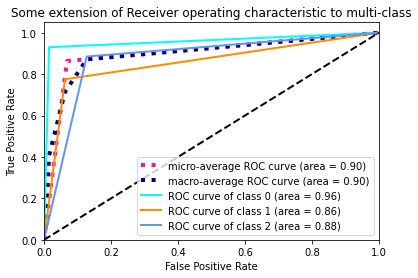

{0: array([0.  , 0.06, 1.  ]), 1: array([0.  , 0.05, 1.  ]), 2: array([0.   , 0.085, 1.   ]), 'micro': array([0.   , 0.065, 1.   ])} {0: array([0.   , 0.985, 1.   ]), 1: array([0.  , 0.78, 1.  ]), 2: array([0.   , 0.845, 1.   ]), 'micro': array([0.  , 0.87, 1.  ])}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


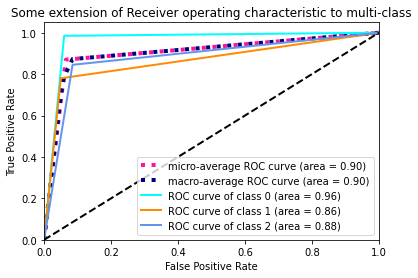

In [ ]:
# These plots are incorrect, Y_test_pred here is supposed to be the predict probas.

In [ ]:
tmp, uwu = Y_test_onehot.copy(), y_proba_pred.copy()

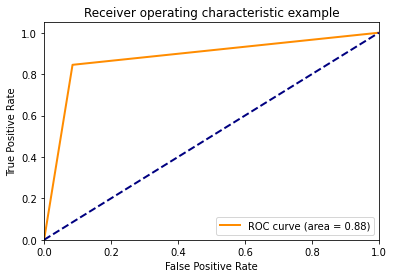

In [ ]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

c = list(zip(Y_test_onehot, y_proba_pred))

random.shuffle(c)

Y_test_onehot, y_proba_pred = zip(*c)
Y_test_onehot = np.array(Y_test_onehot)
y_proba_pred = np.array(y_proba_pred)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(Y_test_onehot[:, i], y_proba_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_onehot.ravel(),y_proba_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
np.array(Y_test_onehot)

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

Cross-Validation Number  7 :


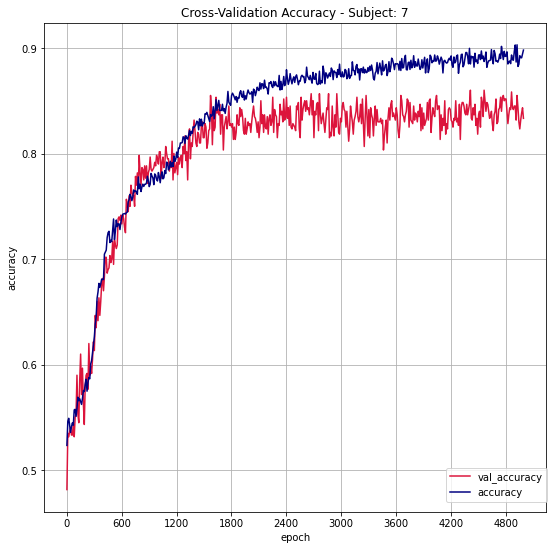

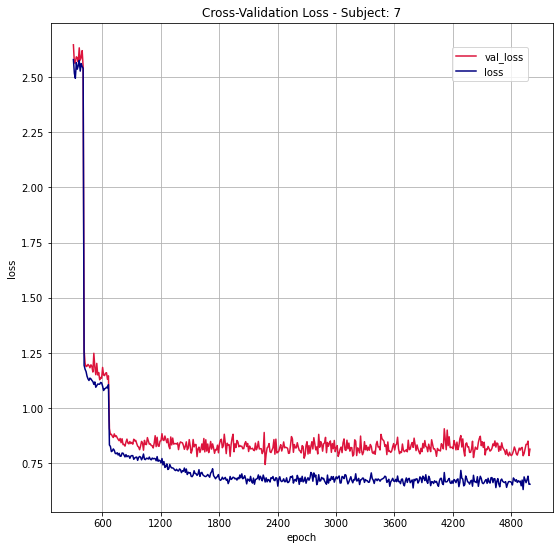

In [10]:
import pandas as pd
tmp = list(range(0,4800,400))
N_Leave_One_Subject = len(tmp)-1
#changed vdcnn_test to plateau
for learn_rate in [0.0045]:
  for leave_one_idx in [7]:
      model_num = leave_one_idx
      print('Cross-Validation Number ',leave_one_idx,':')
      train_result = pd.read_csv(os.path.join('./plateau',f'training_holdout_regularized_{model_num}_{learn_rate}.log'))
      train_result = train_result[train_result.epoch < 5001][train_result.epoch > 1].iloc[::10]
      
      ax = figure(0).gca()
      ax.plot('epoch','val_accuracy',data=train_result,color='crimson')
      ax.plot('epoch','accuracy',data=train_result,color='navy')
      ax.xaxis.set_major_locator(MaxNLocator(integer=True))
      ax.legend(bbox_to_anchor=(0.8, 0.09), loc='upper left', borderaxespad=0.)
      plt.title('Cross-Validation Accuracy - Subject: '+str(leave_one_idx))
      ax.set_xlabel('epoch')
      ax.set_ylabel('accuracy')
      ax.set_yticks(np.arange(0.5,1,0.1))
      fig = ax.get_figure()
      fig.set_figheight(9)
      fig.set_figwidth(9) 
      plt.grid()
      #fig.savefig("fixed-acc_cv"+str(leave_one_idx)+"_lr_"+str(learn_rate)+".png")
      
      train_result = train_result[train_result.epoch > 300]

      ax2 = figure(1).gca()
      ax2.plot('epoch','val_loss',data=train_result,color='crimson')
      ax2.plot('epoch','loss',data=train_result,color='navy')
      ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
      ax2.legend(bbox_to_anchor=(0.8, 0.95), loc='upper left', borderaxespad=0.)
      ax2.set_xlabel('epoch')
      ax2.set_ylabel('loss')
      plt.title('Cross-Validation Loss - Subject: '+str(leave_one_idx))

      fig2 = ax2.get_figure()
      fig2.set_figheight(9)
      fig2.set_figwidth(9)  
      plt.grid()    
      fig2.savefig("fixed-loss_cv"+str(leave_one_idx)+"_lr_"+str(learn_rate)+"_zoom.png")
      
      show()